In [505]:
import pandas as pd
import numpy as np
import json
import pickle
import datetime as dt
import geopandas as gpd
from shapely.geometry import Point, LineString,MultiLineString,Polygon
from shapely import ops
import matplotlib.pyplot as plt
%matplotlib inline
import os
import folium
attr='(c) <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors (c) <a href="http://cartodb.com/attributions">CartoDB</a>, CartoDB <a href ="http://cartodb.com/attributions">attributions</a>'
from selenium import webdriver
import PIL
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import glob
import moviepy.editor as mpy

In [436]:
# populate files in a list
address = "../here_outputs"
files = os.listdir(address)
len(files)

602

In [437]:
# define a function to get important information from HERE Maps API output
def get_resume(data):
    data=data['RWS'][0]
    rws=data['RW']
    fis=[x['FIS'][0]['FI'] for x in rws]
    fisis = [direction for subfis in fis for direction in subfis]
    JFS = [x['CF'][0]['JF'] for x in fisis]
    IDS = [str(x['TMC']['PC'])+x['TMC']['QD'] for x in fisis]
    LIS = [x['LI'] for x in rws]
    SHPS = [x['SHP'] for x in fisis]
    FCS = [np.mean([x['FC'] for x in y]) for y in SHPS]
    SHPS_string=["".join(list(np.array([x['value'] for x in shp]).flatten())) for shp in SHPS]
    df = pd.DataFrame({'JF':JFS,
                       #'SU':SUS,
                       'FC':FCS,'ID':IDS,'shape':SHPS_string})
    return df

In [479]:
# open and process a sample data
fname1='2018-08-07 18-00-00.p'
time1 = dt.datetime.strptime(fname1.split(".")[0], "%Y-%m-%d %H-%M-%S")+dt.timedelta(hours=14) #+14 because I live in PST
data1 = pd.read_pickle(os.path.join(address, fname1))
res1 = get_resume(data1)

In [478]:
# below is a dataframe of the processed traffic on 8/8/2018 at 8 AM
print time1
res1.head()

2018-08-09 08:00:00


FC    ID       JF                                              shape
0  3.0  383+  0.33670             -6.14397,106.88624 -6.14431,106.88613 
1  3.0  382+  0.53954  -6.14431,106.88613 -6.14449,106.88607 -6.14449...
2  4.0  376+  0.00000  -6.13066,106.73404 -6.13069,106.73406 -6.13069...
3  4.0  375+  0.00000  -6.13079,106.73415 -6.13097,106.73428 -6.13097...
4  4.0  374+  0.23255  -6.13668,106.73583 -6.13667,106.73558 -6.13667...

In [443]:
len(res1)


13965

This traffic data contains 13,965 roadway segments. Every segment has unique ID (ID), jam factor (JF) and a road class (FC)

In [444]:
# convert the previous data to a geodataframe
gdf = res1[['ID','shape','FC']].copy()
gdf['geometry'] = gdf['shape'].apply(lambda s: LineString(map(lambda x: Point(eval(x)[::-1]),
                                                                 s.strip().split(" "))))
gdf=gpd.GeoDataFrame(gdf)
gdf.crs = {'init':'epsg:4326'}
gdf.head()

ID                                              shape   FC  \
0  383+             -6.14397,106.88624 -6.14431,106.88613   3.0   
1  382+  -6.14431,106.88613 -6.14449,106.88607 -6.14449...  3.0   
2  376+  -6.13066,106.73404 -6.13069,106.73406 -6.13069...  4.0   
3  375+  -6.13079,106.73415 -6.13097,106.73428 -6.13097...  4.0   
4  374+  -6.13668,106.73583 -6.13667,106.73558 -6.13667...  4.0   

                                            geometry  
0  LINESTRING (106.88624 -6.14397, 106.88613 -6.1...  
1  LINESTRING (106.88613 -6.14431, 106.88607 -6.1...  
2  LINESTRING (106.73404 -6.13066, 106.73406 -6.1...  
3  LINESTRING (106.73415 -6.13079, 106.73428 -6.1...  
4  LINESTRING (106.73583 -6.13668, 106.73558 -6.1...

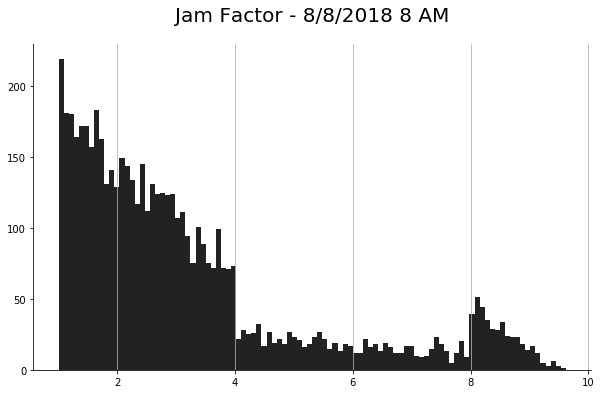

In [514]:
# now let's take a look at the jam factor
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
res1[res1.JF>1].JF.hist(bins=100, color="#222222",ax=ax)
ax.set_title("Jam Factor - 8/8/2018 8 AM", fontsize=20, y=1.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis="y")

At 8 AM, one of the rush hours, we can see stark differences/steep steps in some values such as from JF<4 and JF>4 as well as JF<8 and JF>8. Therefore, we'll cut the data into some groups based on clusters we see above

In [446]:
res1['group']=pd.cut(res1.JF,[-1,1,3,4,8,11]).cat.codes

Since my current geodataframe has a quite big coverage (up to Bogor), I want to limit that so that it doesn't take up so much space later

In [449]:
# my geo
u,l=-6.049427, 106.525587
b,r=-6.511087, 107.183457
x = [l,r,r,l]
y = [b,b,u,u]
bound=Polygon([[px, py] for px,py in zip(x,y)])
bd=gpd.GeoDataFrame(pd.Series([bound]).reset_index().rename(columns={0:'geometry'}))
bd.crs={'init':'epsg:4326'}
gdf_ok = gpd.sjoin(gdf,bd)

now let's merge the geodataframe with the dataframe containing JF info

In [453]:
gdf_w_data = pd.merge(gdf_ok,res1[['ID','JF',
                                #'SU',
                                'group']],on="ID")

Here is how the data on 8/8/2018 looks like when plotted

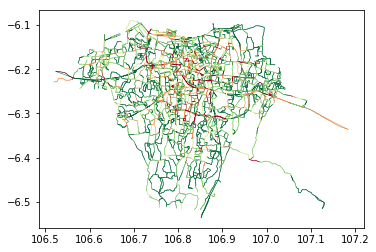

In [465]:
gdf_w_data.sort_values("JF").plot(column="group", cmap='RdYlGn_r', categorical=True, linewidth=.5)

Looks good, but we can't really see the detail so let's plot in on folium

In [468]:
# define a function to plot lines on folium and save it as HTML
def plot_folium(tes, fname, save=True):
    m=folium.Map((-6.223996, 106.828303), zoom_start=12,
                tiles="https://cartodb-basemaps-{s}.global.ssl.fastly.net/dark_nolabels/{z}/{x}/{y}.png",
                #tiles = "https://{s}.basemaps.cartocdn.com/base-dark/{z}/{x}/{y}.png",
                 attr=attr)
    color={2:'#069E2D',0:'#034732',1:'#008148',3:'#F5BB00',4:'#FB5012'}
    style_function = lambda x: {
        'color' : color[x['properties']['group']],
        'weight' : 5/x['properties']['FC']
    }
    tes_=tes
    for wi in np.sort(tes['FC'].unique())[::-1]:
            for c in np.sort(tes['group'].unique()):
                the_df=tes_[(tes_['FC']==wi)&(tes_['group']==c)]
                if len(the_df)==0:
                    continue
                else:
                    folium.GeoJson(the_df, style_function=style_function).add_to(m)
    if save==True:
        m.save(fname)
    else:
        return m


#m

In [509]:
# here is the example of the first 1000 line segments
plot_folium(tes.head(1000), "test.html", save=False)

Now, streamline all functions so that for every HERE Maps output, we have their own html file of mapped roadways

In [39]:
def process(fname1):
    #fname1='2018-08-07 18-00-00.p'
    time1 = dt.datetime.strptime(fname1.split(".")[0], "%Y-%m-%d %H-%M-%S")+dt.timedelta(hours=14)
    data1 = pd.read_pickle(os.path.join(address, fname1))
    
    # get important information
    res1 = get_resume(data1)
    res1['group']=pd.cut(res1.JF,[-1,1,3,4,8,11]).cat.codes
    
    # merge it with data frame
    tes = pd.merge(gdf_ok,res1[['ID','JF',
                                #'SU',
                                'group']],on="ID")
    # save to folium
    plot_folium(tes, os.path.join("../htmls/",str(time1).replace(":","-")+".html"))
    return tes

Uncomment these lines to run them all

In [ ]:
# all_data = {}
# for i,f in enumerate(files):
#     try:
#         time1 = dt.datetime.strptime(f.split(".")[0], "%Y-%m-%d %H-%M-%S")+dt.timedelta(hours=14)
#         fout = str(time1).replace(":","-")+".html"
#         if fout not in outs:
#             tes = process(f)
#             all_data[f] = tes['JF']
#         else:
#             continue
#         print "\r",str(i),
#     except:
#         print "\r","failed ",str(i),

523                                                                                                                                                       

Now I will use selenium to screencapture every single html maps to PNG files. I know it's not the smartest thing.
Uncomment these lines to export all pngs

In [473]:
# def sreenshot(html_file):
#     # change this with yours
#     base  = "file:///C:/Users/NMonarizqa/Documents/routing_1/htmls/"
#     delay=5
#     browser = webdriver.Chrome()
#     browser.get(html_file)

#     time.sleep(delay)
#     browser.save_screenshot("../pngs/"+html_file.replace("html","png"))
#     browser.quit()

In [475]:
# for f in os.listdir("../htmls"):
#     screenshot(f)

Now let's import one of our pngs

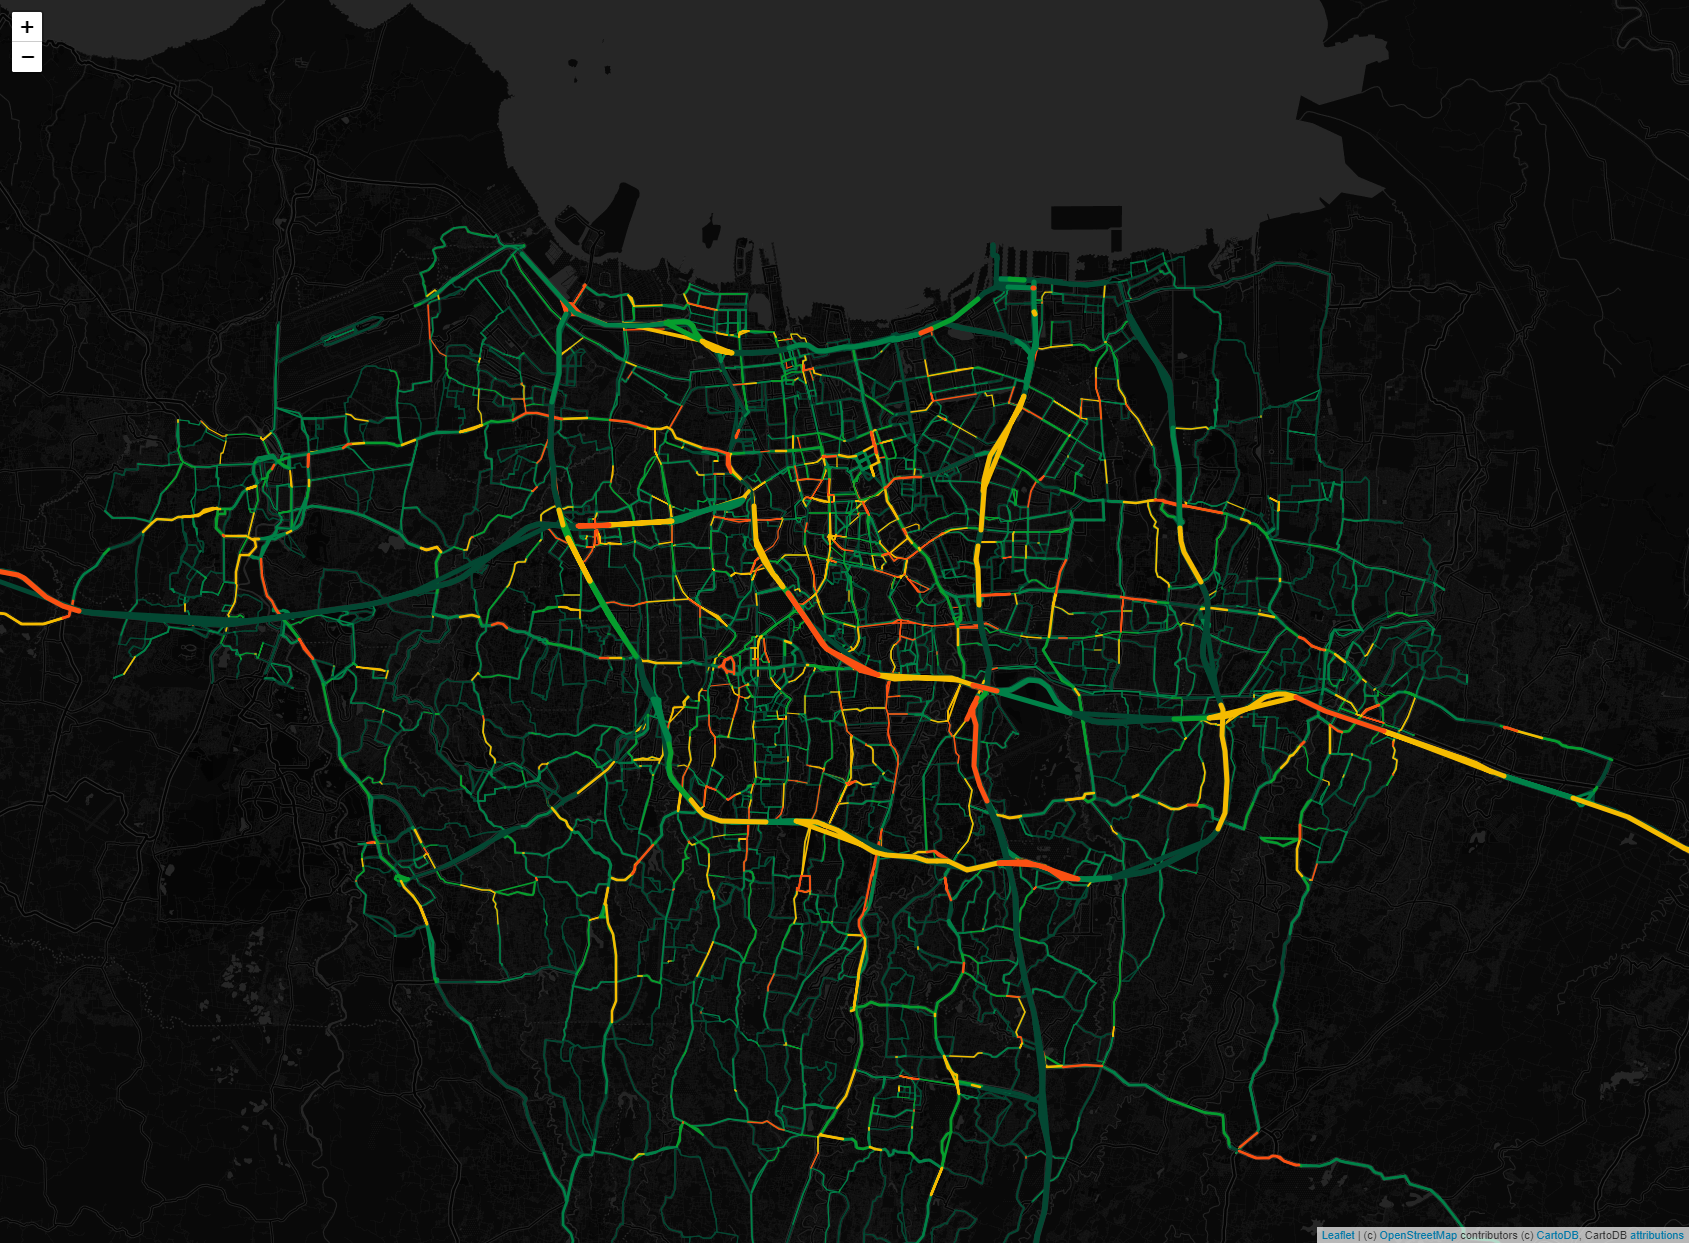

In [482]:
folder = "../pngs/"
image = Image.open('../pngs/2018-08-08 08-00-00.png')
image

Looks good, but now let's add some caption to provide some informations

In [483]:
daydict = {0:'s e n i n',
          1:'s e l a s a',
          2: 'r a b u',
          3:'k a m i s',
          4:'j u m a t', 5:'s a b t u', 6:'m i n g g u'}
def get_crop(infile):
    f = infile.split("\\")[-1]
    original = Image.open(folder+f)
    the_date = dt.datetime.strptime(f.split(".")[0], "%Y-%m-%d %H-%M-%S")
    
    # crop image
    width, height = original.size  
    left = width/9
    top = height/6
    right = 8*width/9
    bottom = 7 * height/8
    cropped_example = original.crop((left, top, right, bottom))
    draw = ImageDraw.Draw(cropped_example)
                                    
    # captions                                
    day=daydict[the_date.weekday()].upper()
    hour=str(the_date.hour).zfill(2)+":"+str(the_date.minute).zfill(2)
    bottomword=str(the_date.day)+" Agustus "+str(the_date.year)
    
    # initialize position
    the_x=1050
    start_y=730
                                    
    # write hours                               
    font = ImageFont.truetype('../../Montserrat-ExtraBold.ttf', size=60)
    # the x position is relative to the minute value
    (x, y) = (50+((cropped_example.size[0]-100)/28.5)*(the_date.hour+the_date.minute*1./60), start_y)
    color = 'rgb(255, 255, 255)' 
    draw.multiline_text((x, y), hour, fill=color, font=font, align="right")

    # write day
    day_x=50+((cropped_example.size[0]-150)/7)*(the_date.weekday())
    font = ImageFont.truetype('../../Montserrat-Regular.ttf', size=30)
    # the x position is relative to the day value
    (x, y) = (day_x, start_y+60)
    color = 'rgb(255, 255, 255)'
    draw.text((x, y), day, fill=color, font=font)

    # write date
    font = ImageFont.truetype('../../Montserrat-ExtraBold.ttf', size=25)
    (x, y) = (day_x, start_y+90)
    color = 'rgb(175, 171, 171)'
    draw.text((x, y), bottomword, fill=color, font=font)
                                    
    return cropped_example

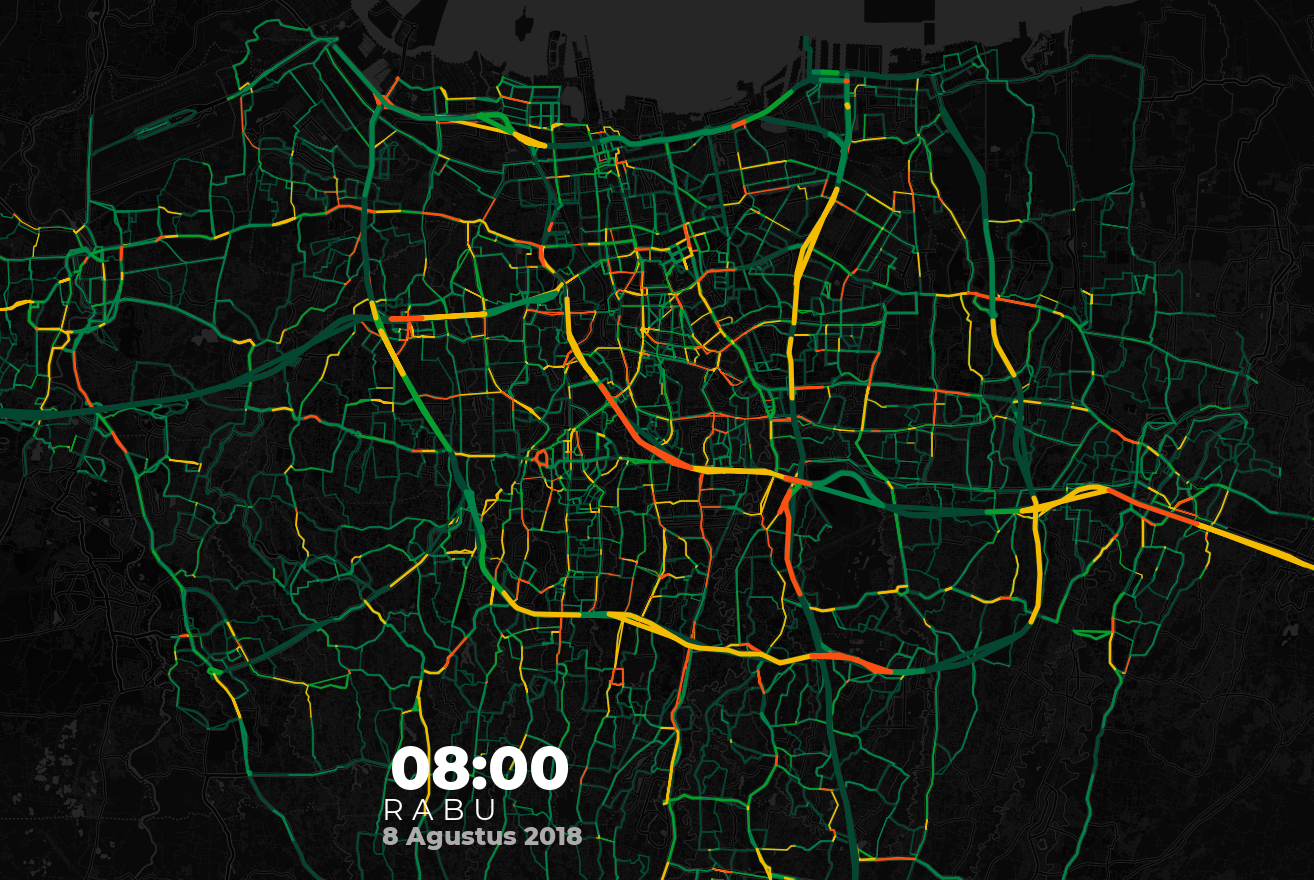

In [485]:
cropped_example=get_crop('2018-08-08 08-00-00.png')
cropped_example

Ok cool, now uncomment lines below to do the iteration

In [ ]:
# # specify your own file_list
# file_list = []
# for f in os.listdir("../pngs/"):
#     file_list+=glob.glob('../pngs/'+f+'/*.png')
# fl=file_list[2*48:-48]

# # iterate for all raw png
# for f in fl:
#     cropped_example=get_crop(f)
#     cropped_example.save(f,format="PNG")


Let's create the gif and video from all edited pngs

In [488]:
# my list of all edited images is "fl". Just edit this line as you want
fl[:10]

['../maps/maps_out/13-08-2018\\2018-08-13 00-00-00.png',
 '../maps/maps_out/13-08-2018\\2018-08-13 00-30-00.png',
 '../maps/maps_out/13-08-2018\\2018-08-13 01-00-00.png',
 '../maps/maps_out/13-08-2018\\2018-08-13 01-30-00.png',
 '../maps/maps_out/13-08-2018\\2018-08-13 02-00-00.png',
 '../maps/maps_out/13-08-2018\\2018-08-13 02-30-00.png',
 '../maps/maps_out/13-08-2018\\2018-08-13 03-00-00.png',
 '../maps/maps_out/13-08-2018\\2018-08-13 03-30-00.png',
 '../maps/maps_out/13-08-2018\\2018-08-13 04-00-00.png',
 '../maps/maps_out/13-08-2018\\2018-08-13 04-30-00.png']

In [426]:
gif_name = 'outputName'
fps = 12

# here I use fl to create the sequence
clip = mpy.ImageSequenceClip(fl, fps=fps)
clip.write_gif('{}.gif'.format(gif_name), fps=fps)


[MoviePy] Building file outputName.gif with imageio


100%|████████████████████████████████████████████████████████████████████████████████| 336/336 [01:26<00:00,  3.89it/s]


export to video

In [428]:
myclip = mpy.VideoFileClip('outputName.gif')
myclip.write_videofile("movie.mp4", fps=12)

[MoviePy] >>>> Building video movie.mp4
[MoviePy] Writing video movie.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [00:23<00:00, 13.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie.mp4 



In [519]:
gif_name = '../senin_pagi'
fps = 3

# here I use fl to create the sequence
clip = mpy.ImageSequenceClip(fl[10:15], fps=fps)
clip.write_gif('{}.gif'.format(gif_name), fps=fps)


[MoviePy] Building file ../senin_pagi.gif with imageio


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:01<00:00,  4.68it/s]
